# 图像滤波

通过修改像素值，改变像素周围的像素值来达到去噪、平滑、锐化的目的。

### 应用

* 去噪声
* 锐化、平滑
* 边缘检测
* 形态学处理：处理二值图像
* 图像重构：强化重点，弱化其他内容(语义上的去噪声)

### 主要分类

* 线性滤波
* 非线性滤波
* 锐化滤波
* 频域滤波
* 自适应滤波

### 图像去噪

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('../../dataset/lena.png', 0)

# 生成噪声
mean = 0
sigma = np.sqrt(.2)
noise = np.random.normal(mean, sigma, img.shape)
print(noise[:10])
noise = noise.reshape(img.shape[:2])
print(noise.shape)

[[ 0.02021411 -0.61829162  0.53626236 ...  0.08575902 -0.00732753
  -0.15096654]
 [ 0.5346883  -0.35822161  0.74875512 ... -0.90667044 -0.10146101
   0.24416729]
 [-0.50384375  0.0194936   1.06903685 ...  0.09110116 -0.17375951
  -0.79250608]
 ...
 [-0.7406097   0.0434444  -0.04171656 ... -0.44543929  0.33035026
   0.9626976 ]
 [-0.1015742  -0.31424595  0.86529731 ... -0.07948536 -0.08800841
   0.49280048]
 [-0.20467646  0.02841859 -0.85552655 ... -0.51526584  0.01175184
  -0.36598884]]
(512, 512)


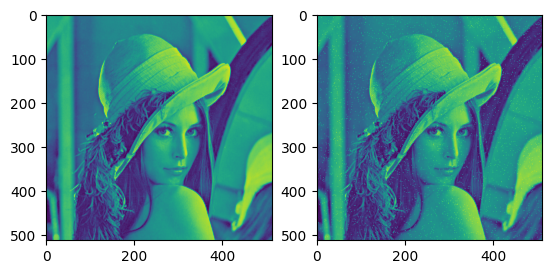

In [3]:
noise_img = cv2.add(img, noise.astype(np.uint8))
cv2.imwrite('../../dataset/noise_lena.png', noise_img)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(noise_img)
plt.show()

#### 线性滤波

哪里有线性：通过将目标像素周围的像素进行加权平均或者求和，得到目标像素的灰度值。**卷积核**

* 均值滤波
* 中值滤波（非线性）
* 高斯滤波
* 双边滤波


**均值滤波**

均值滤波和卷积有什么关系？

* 方案一：底层实现
* 方案二：opencv函数

In [4]:
import cv2

img = cv2.imread("../../dataset/noise_lena.png", 0)
h, w = img.shape

# 定义滤波核
kernel_size = 11
kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)

(522, 522) (512, 512)
(512, 512)


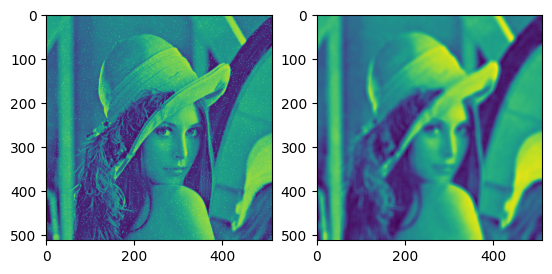

In [9]:
# 方案一
# 添加pand
padding = kernel_size // 2
# 对图像进行填充，这里使用了复制边界的方式
img_pad = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_REPLICATE)
print(img_pad.shape, img.shape)
# 构建输出图像
img_out = np.zeros((h, w), dtype=np.uint8)
# 进行卷积操作
for i in range(padding, h+padding):
    for j in range(padding, w+padding):
        # 对于每个像素，取它周围kernel_size*kernel_size个像素的平均值，作为它的输出值
        roi = img[i-padding:i+padding+1, j-padding:j+padding+1]
        img_out[i-padding, j-padding] = np.mean(roi, axis=(0, 1))

print(img_out.shape)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_out)
plt.show()

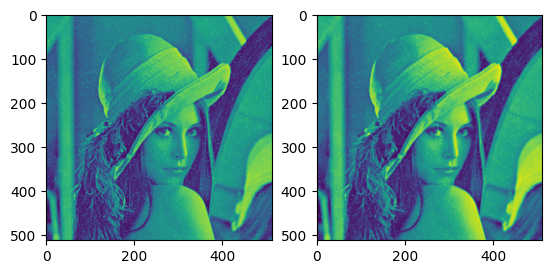

In [48]:
# 方案二

# 定义均值卷积核
kernel = np.ones((kernel_size, kernel_size), np.float32) / kernel_size**2
# 对图像进行卷积操作
img_out = cv2.filter2D(img, -1, kernel)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_out)
plt.show()

`cv2.filter2D(src, ddepth, kernel[, dst[, anchor[, delta[, borderType]]]]) -> dst`

- src：输入图像
- ddepth：输出图像的深度，如果为-1，则输出图像的深度与输入图像一致。
- kernel：卷积核
- dst：输出图像
- anchor：卷积核中心的位置，默认值为(-1, -1)，表示卷积核的中心点为卷积核的中心。
- delta：可选的增量，用于调整卷积的结果。
- borderType：边界填充方式，默认值为cv2.BORDER_DEFAULT。


In [49]:
psnr_opencv = cv2.PSNR(img_out, img)
print(psnr_opencv)

24.22095037047515


#### 中值滤波

处理椒盐噪声和斑点噪声

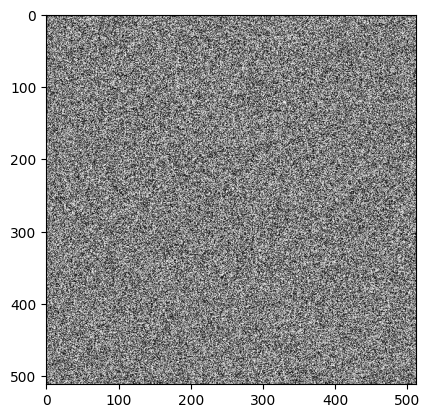

In [47]:
# 中值滤波

# 读取图像
img = cv2.imread('../../dataset/lena.png', 0)

# 添加椒盐噪声
noise = np.zeros_like(img)
cv2.randu(noise, 0, 255)
salt = noise > 250
pepper = noise < 5

plt.imshow(noise, cmap='gray')
plt.show()

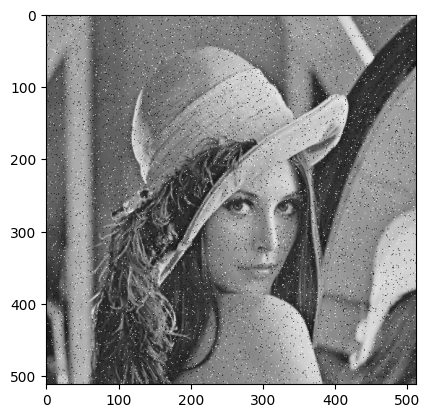

In [48]:
img[salt] = 255
img[pepper] = 0
plt.imshow(img, cmap='gray')
plt.show()

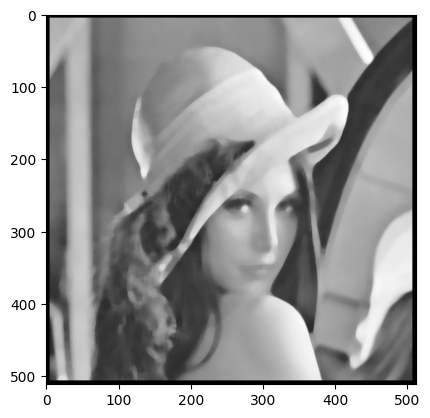

In [53]:
# 去噪声

h, w = img.shape
ksize = 11
pad = ksize // 2
result = np.zeros_like(img)
for y in range(pad, h-pad):
    for x in range(pad, w-pad):
        windows = img[y - pad: y + pad + 1, x - pad: x + pad + 1]
        result[y, x] = np.median(windows)

plt.imshow(result, cmap='gray')
plt.show()

#### 高斯滤波

去除高斯噪声，但保留图像细节信息

主要思想：对每个像素加权平均，权重由高斯函数确定。通常：越近的点权重越高，越远的点权重越低

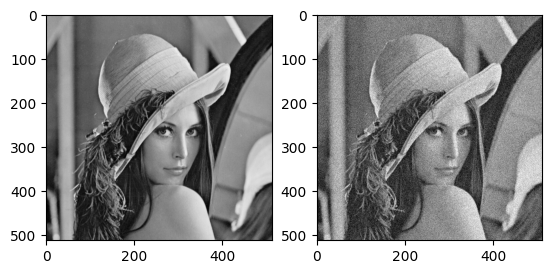

In [54]:
# 读取图像并添加噪声

img = cv2.imread('../../dataset/lena.png', 0)

noise = np.random.normal(0, 20, img.shape)
noisy_img = np.clip(img + noise, 0, 255).astype(np.uint8)

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(noisy_img, cmap='gray')
plt.show()

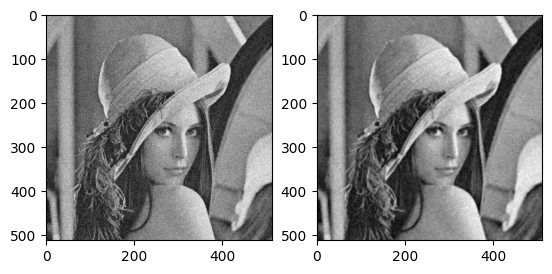

In [55]:
# 高斯滤波

blur = cv2.GaussianBlur(noisy_img, (5, 5), 0)

plt.subplot(1, 2, 1)
plt.imshow(noisy_img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(blur, cmap='gray')
plt.show()

### 评价去噪

$$\text{PSNR} = 10 \log_{10}\left(\frac{MAX_I^2}{MSE}\right)$$

其中，$MAX_I$是像素值的最大值(255)

$MSE$是均方误差

$$MSE = \frac{1}{mn}\sum_{i=0}^{m-1}\sum_{j=0}^{n-1}(I(i,j)-K(i,j))^2$$

其中，
- $I$和$K$分别表示原始图像和压缩后的图像，
- $m$和$n$分别表示图像的宽度和高度，
- $I(i,j)$和$K(i,j)$分别表示原始图像和处理后的图像在像素点$(i,j)$处的像素值。



In [56]:
psnr_opencv = cv2.PSNR(blur, img)
print(psnr_opencv)

30.10338283650188


In [57]:
mse = np.mean((blur-img) ** 2)
psnr = 10 * np.log10((255 ** 2) / mse)
print('PSNR:', psnr)

PSNR: 31.934789828562202


#### 双边滤波

双边滤波是一种非线性滤波方法，可以平滑图像并保持边缘的清晰度。

主要思想：它使用一个窗口对图像进行滑动，不仅考虑空间距离上的相似度，还考虑像素值相似度，从而达到去除噪声的目的。

(512, 512) (512, 512)


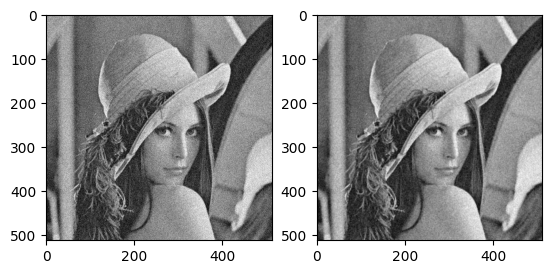

In [62]:
# 进行双边滤波
d = 1
sigmaColor = 75
sigmaSpace = 255

# 对图像进行双边滤波
filtered = cv2.bilateralFilter(noisy_img, d, sigmaColor, sigmaSpace)
print(img.shape, filtered.shape)

# 显示结果
plt.subplot(1, 2, 1)
plt.imshow(noisy_img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(filtered, cmap='gray')
plt.show()

In [102]:
psnr_opencv = cv2.PSNR(filtered, img)
print(psnr_opencv)

30.18670321827733


sigmaspace参数

对于灰度图像，高斯函数的标准差控制了像素在灰度值上的权重。

较小时，只有灰度值相近的像素会对当前像素滤波，从而保留更多细节，但也保留噪声

较大时，更多的像素会对当前像素滤波，更好的平滑图像去除噪声，但导致细节信息的丢失

**和窗口尺寸配合使用**

#### 锐化滤波

图像增强技术，通过滤波实现图像边缘和细节的增强

* 拉普拉斯滤波器
* sobel滤波器

#### 拉普拉斯滤波器

步骤：

1. 拉普拉斯变换
2. 原始图像和拉普拉斯图像相加

**什么是拉普拉斯变换** 

将图像从时间域变为频率域。

对于一个实函数 $f(x)$，它的拉普拉斯变换 $F(s)$ 定义为：

$$F(s) = \int_{0}^{\infty} e^{-sx} f(x) dx$$

其中 $s$ 是复数，可以是实部和虚部都是实数的情况，也可以是实部为0的情况。



对于一个二维信号，他的拉普拉斯变换为：

$$F(s_x,s_y)=\mathcal{L}{f(x,y)}=\int_{-\infty}^\infty \int_{-\infty}^\infty e^{-(s_x x+s_y y)}f(x,y)dx dy$$



其中，$s_x$和$s_y$是拉普拉斯变换的参数。在这个定义中，拉普拉斯变换的核是一个二维高斯函数。

根据函数$f(x,y)$的不同性质，它的拉普拉斯变换可以用来描述不同的现象。

对于一个图像$f(x,y)$，它的拉普拉斯变换可以提供图像的频域信息，例如边缘、纹理等，从而可以进行图像增强、滤波等操作。

拉普拉斯变换载图像中的一个典型应用就是

下面给出一个简单的例子，说明拉普拉斯变换在图像处理中的应用。考虑一个有噪声的图像$f(x,y)$，它可以表示为：

$$f(x,y) = g(x,y) + n(x,y)$$

其中，$g(x,y)$是原始图像，$n(x,y)$是加入的噪声。

使用高斯滤波器对原始图像进行平滑处理

然后将平滑后的图像与原始图像相减，得到噪声图像$n(x,y)$。

最后，将噪声图像$n(x,y)$与原始图像相减，得到去噪后的图像$g'(x,y)$。

这个过程可以用拉普拉斯变换的形式表示为：

$$G'(s_x,s_y) = \frac{G(s_x,s_y)}{H(s_x,s_y)}\cdot H(s_x,s_y) - \frac{N(s_x,s_y)}{H(s_x,s_y)}\cdot H(s_x,s_y)$$

其中，$G(s_x,s_y)$和$N(s_x,s_y)$分别是原始图像$f(x,y)$和噪声图像$n(x,y)$的拉普拉斯变换，$H(s_x,s_y)$是高斯滤波器的拉普拉斯变换。

如果对图像这种离散信号做拉普拉斯变换的处理，则可以认为是一个拉普拉斯卷积核(拉普拉斯算子)对图像进行卷积处理。

那么卷积核可以表示为

    0  1  0
    1 -4  1
    0  1  0

上述卷积中，中心权重为-4， 说明中心像素与周围像素差异最大；

其余为1的权重表示周围像素与中心像素差异相对较少

档卷积核与图像进行卷积时，中心像素会被周围像素的平均值减去一个比较大的差异，从而突出图像中的边缘信息。

# 例如，我们构造一个小矩阵如下

```
0 0 0 0
0 1 1 0
0 1 1 0
0 0 0 0

```

已知拉普拉斯矩阵的算子为：
```
0 1 0
1 -4 1
0 1 0
```

卷积后，得到

```
0 1 1 0
1 -2 -2 1
1 -2 -2 1
0 1 1 0
```

相比较于之前的特征，目标区域的强度得到增强，和其他区域的对比幅度增加，因而能够强化边缘和细节特征。

另一种典型的拉普拉斯算子进阶版为又称为LoG卷积核

```
    0  -1  0
    -1  4 -1
    0  -1  0
```

检测图像中的斑点和斑块

**拉普拉斯滤波的底层实现**

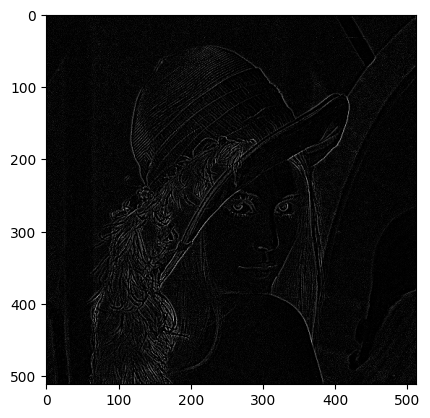

In [63]:
import cv2
import numpy as np

# 读取图像并转为灰度图像
img = cv2.imread('../../dataset/lena.png', cv2.IMREAD_GRAYSCALE)

# 定义拉普拉斯滤波器卷积核
kernel = np.array([[0, 1, 0],
                   [1, -4, 1],
                   [0, 1, 0]])

# kernel = np.array([[0, -1, 0],
#                    [-1, 4, -1],
#                    [0, -1, 0]])

# 应用卷积核
filtered_img = cv2.filter2D(img, -1, kernel)

plt.imshow(filtered_img, cmap='gray')
plt.show()

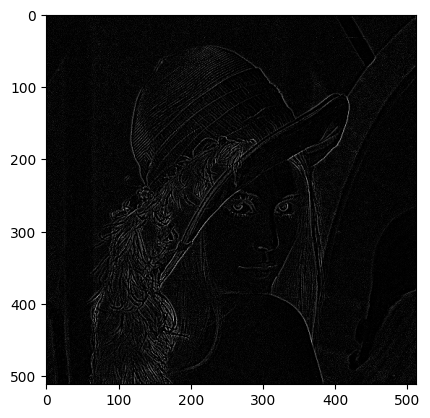

In [26]:
laplacian = cv2.Laplacian(img, cv2.CV_64F)

plt.imshow(filtered_img, cmap='gray')
plt.show()

#### 锐化-拉普拉斯

既然我们已经获得了边缘，如何对图像实现锐化处理？

`exp1`


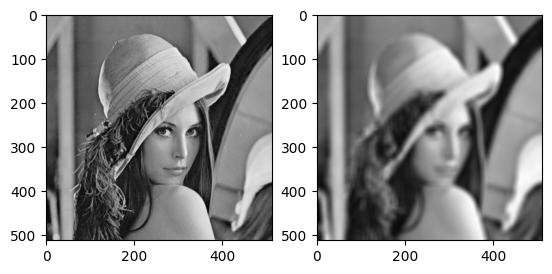

In [27]:
gray = cv2.imread('../../dataset/lena.png', 0)
blur_img = cv2.GaussianBlur(gray, [15, 15], 10)

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(blur_img, cmap='gray')
plt.show()

#### sobel算子

Sobel算子是一种常用的边缘检测算子

它可以对图像进行一阶导数的计算，以检测出图像中的边缘信息。

在图像处理中，Sobel算子通常用来检测图像在水平和垂直方向上的边缘

原理：利用一组固定的卷积核对图像进行卷积运算，得到图像在水平和垂直方向上的梯度值，从而找到边缘位置。


特点：从水平和垂直两个方向检测边缘

水平方向的卷积核
```
-1 0 1
-2 0 2
-1 0 1
```
垂直方向的卷积核

```
-1 -2 -1
 0  0  0
 1  2  1
```

步骤：

* 计算水平方向和垂直方向的卷积结果

* 将两个卷积结果求平方和以后载开根号

求的卷积结果，分别表示水平和垂直方向上的边缘强度

平方和开根号，则表示边缘的清晰度。

#### 课堂练习：实现sobel边缘检测

#### prewitt算子

与sobel类似，水平和垂直方向分别做卷积。

其算子为：

```
水平方向：
-1  0  1
-1  0  1
-1  0  1

垂直方向：
-1 -1 -1
 0  0  0
 1  1  1

```

**课堂练习：实现prewitt滤波**

### 频域滤波

频域滤波是指，在频域将图像信号进行滤波，允许或阻止某个频段的信号，来实现相应的功能。

* 频域与时域的转换

    - 利用傅立叶变换或余弦变换，将时域信号转换成频域信号；
    - 处理后，将频域信号利用逆变换将频域信号转换到时域
    - 变换时，需要使用快速离散傅立叶变换(dft)和快速傅立叶逆变换(idft)
    - 常用的算法是FFt(快速傅立叶变换和离散余弦变换等)
    
* 频域信号的处理
    - 低通滤波：只允许低频信号通过，滤除高频信号
    - 高通滤波器
    - 带通
    - 带阻

(512, 512)


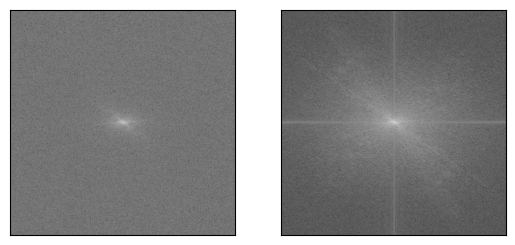

In [37]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 读入图像
img = cv2.imread('../../dataset/noise_lena.png', 0)
img_2 = cv2.imread('../../dataset/lena.png', 0)

# 进行傅里叶变换
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
print(fshift.shape)

f_2 = np.fft.fft2(img_2)
fshift_2 = np.fft.fftshift(f_2)

# 计算幅度谱
magnitude_spectrum = 20*np.log(np.abs(fshift))
magnitude_spectrum_2 = 20*np.log(np.abs(fshift_2))

# 可视化幅度谱
plt.subplot(121), plt.imshow(magnitude_spectrum, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum_2, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()


(512, 512, 2)


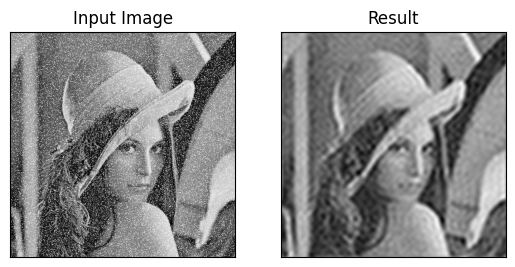

In [42]:
# 生成一个掩膜
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)


rows, cols = img.shape
crow, ccol = rows//2, cols//2
mask = np.zeros((fshift.shape[0], fshift.shape[1], 2), np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# 应用掩膜
fshift = dft_shift * mask

# 进行傅里叶反变换
ishift = np.fft.ifftshift(fshift)
iimg = cv2.idft(ishift)
print(iimg.shape)
img_back = cv2.magnitude(iimg[:,:,0], iimg[:,:,1])

# 绘制结果
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_back, cmap='gray')
plt.title('Result'), plt.xticks([]), plt.yticks([])
plt.show()


### 自适应滤波

自适应滤波是一种图像滤波方法，它可以根据局部区域内的像素值进行自适应调整滤波器的大小和权重，从而更好地处理图像中的噪声和细节。

主要思想是根据局部像素的方差来调整滤波器的参数，使得在有噪声的情况下可以有效地去除噪声，同时保留图像的边缘和细节信息。

基本步骤：

- 在图像上滑动一个窗口，在窗口内计算像素的均值和方差。
- 根据窗口内像素的方差调整滤波器的参数，使得滤波器能够更好地去除噪声。
- 将滤波器应用到当前像素上，计算输出像素的值。
- 重复上述步骤直到图像中所有的像素都被处理。

自适应滤波的具体实现有很多种方法，其中最常见的是基于高斯分布的自适应滤波。

在这种方法中，滤波器的权重是根据局部像素的距离来计算的，距离越近的像素权重越大，距离越远的像素权重越小，

这样可以有效地保留图像的边缘和细节信息。